In [1]:
from data_utils import MultimodalDataset, plot_hist
from utils import train, inference
from config import Config
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

/home/vlabs/Documents/Yandex_Practicum_ML_CV/venv_sprint_4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Посмотрим на датасет. \
Какие у нас есть данные ?
  - Список ингредиентов
  - Изображения еды
  - Калорийность
  - Масса

Очень хочется избавиться от всего, что необязательно подавать в сеть для обучения. \
Например, калорийнось линейно зависит от массы. Возможно, стоит разделить одно на другое.

100%|██████████| 507/507 [00:06<00:00, 77.11it/s]


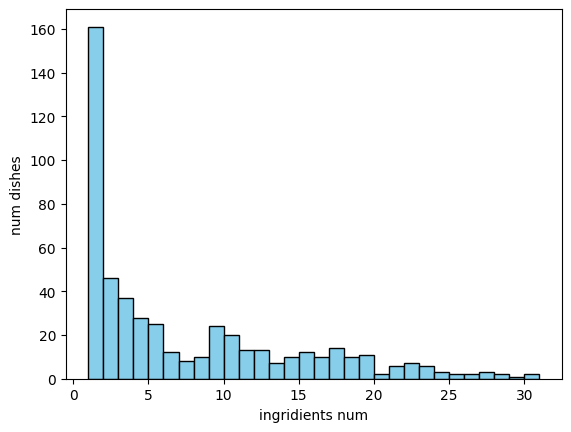

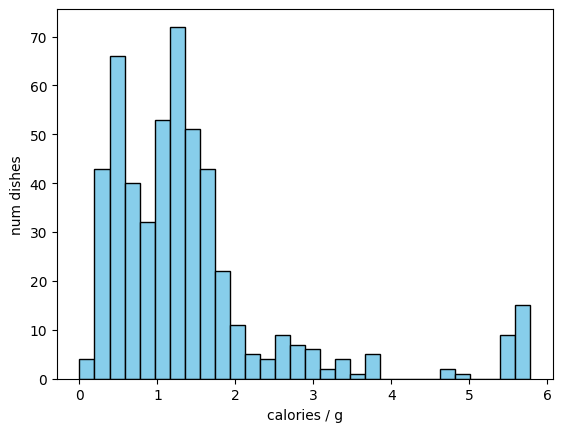

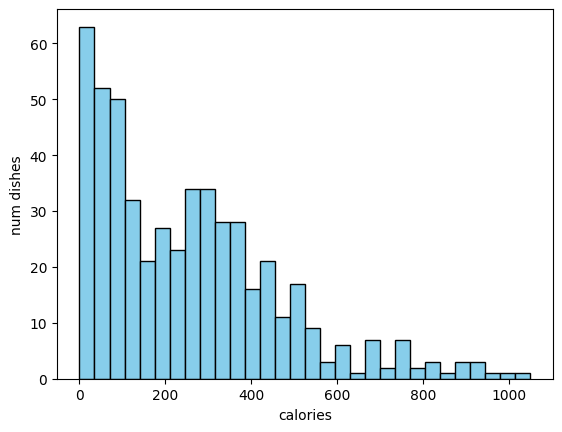

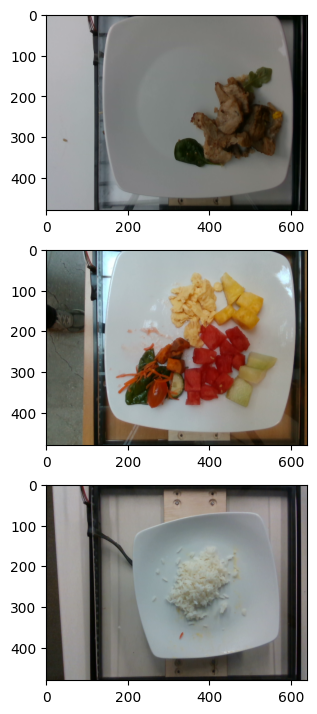

In [2]:
cfg = Config()

# Датасет для валидации меньше размером, оценим его
data_set = MultimodalDataset(cfg, ds_type='test')
for k, v in data_set.summary().items():
    plot_hist(v, k)

fig = plt.figure(figsize=(10, 30))
for i in range(0, 3):
    image = data_set[np.random.randint(0, len(data_set))]['image']
    plt.subplot(10, 1, i+1)
    plt.imshow(image, cmap='gray')

Что мы видим ?
  - Многие блюда состоят из одного ингридиета, что, наверное, хорошо для обучения. У сети будет шанс выучить связь между отдельным ингридиентом и его калорийностью.
  - Многие ингридиенты - мелкие объекты. Дропаут на картинках делать не нужно, можем потерять часть важной информации.
  - Не всегда тарелка попадает в кадр целиком, значит можем делать случайный кроп безбоязненно. Хуже не станет.
  - Афинные преобразования тоже стоит добавить. Пользователи будут фотографировать еду с разных ракурсов на разные камеры.
  - Искажения цвета не помешают. Вдруг юзер ужинает при свечах ?
  - Тарелки занимают приличную часть кадра, можно обойтись без препроцессинга изображений.
  - Все фото - вид сверху. Из них не выйдет извлечь много информации о массе блюда. Сеть не знает, что перед ней: полная тарелка или полная кастрюля. Значит, лучше предсказывать относительную калорийность.

Как будем решать задачу ?
  - Возьмём сеть для классификации изображений, с её помощью будем извлекать информацию об ингридиентах.
  - И сеть для извлечения информации о списке ингридиентов.
  - Эмбеддинги картинок и ингридиентов подадим в простую модель для регрессии. Возвращать она будет относительную калорийность блюда.
  - Т. к. мы считаем абсолютную среднюю ошибку предсказания и хотим уложиться в порог +- 50 калорий, то метрику стоит считать на предсказанной относительной калорийности, помноженной на массу.
  - Максимальное число эпох - 30, прервёмся если МАЕ не улучшается в течение 5 эпох

#### Обучаем модель

In [3]:
if not os.path.exists(cfg.PTH_PATH):
    train(cfg)

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

Загрузим лучшую модель для инференса

In [4]:
result = inference(cfg)
result = dict(
    sorted(result.items(), key=lambda item: item[1][2], reverse=True))

100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


Посмотрим, с какими блюдами модель справилась хуже всего

dish_1566501594: (np.float32(508.04898), np.float32(86.3183), np.float32(421.73068))
dish_1565811139: (np.float32(902.2), np.float32(546.45337), np.float32(355.74664))
dish_1563478751: (np.float32(950.3951), np.float32(600.7156), np.float32(349.6795))
dish_1565123881: (np.float32(406.82175), np.float32(755.0837), np.float32(348.26193))
dish_1558549806: (np.float32(781.958), np.float32(459.77325), np.float32(322.18475))
dish_1566328831: (np.float32(941.61), np.float32(652.51733), np.float32(289.09265))


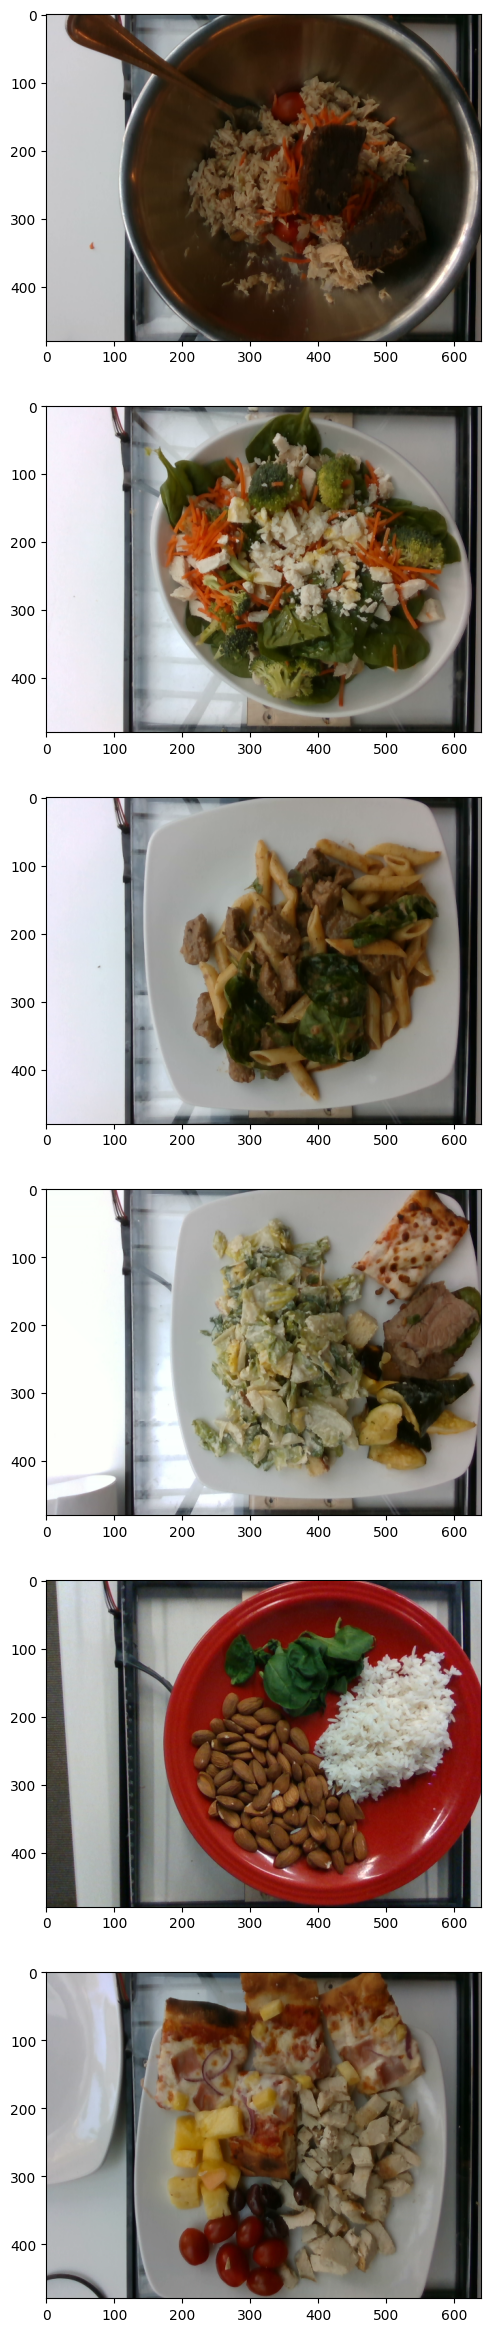

In [5]:
fig = plt.figure(figsize=(10, 50))
for i, val in enumerate(result.items()):
    id, calories = val
    print(f"{id}: {calories}")
    img = Image.open(os.path.join(cfg.IMG_PATH, id, 'rgb.png')).convert('RGB')
    plt.subplot(10, 1, i+1)
    plt.imshow(img, cmap='gray')
    if i > 4:
        break

Почему сеть показала плохой результат на этих блюдах ?
  - Все блюда за исключением того, что сделано из риса, миндаля и шпината - не самые простые для оценки. Много ингредиентов вперемешку + ингредиенты перекрывают друг друга. Полагаю, поэтому сеть для изображений не смогла вытащить достаточно полезной информации.
  - Блюдо из миндаля, риса и шпината - весьма странное. Орехов больше, чем риса. Больше похоже на контрпример от создателей датасета. Возможно, по этой причине сеть серьёзно недооценила калорийность.